In [1]:
import utils
# Set the desired seed value
seed = utils.seed
utils.set_seed(seed)

import  torch,tqdm,time,random
import  numpy               as      np
from    torch.utils.data    import  DataLoader

import dataloaders,nets,deeplearning

       premise  hypothesis
label                     
c         2389        2389
e         2429        2429
n         2448        2448 

       premise  hypothesis
label                     
c          499         499
e          515         515
n          523         523 

       premise  hypothesis  hard(hypothesis)  hard(overlap)
label                                                      
c          510         510               510            510
e          519         519               519            519
n          535         535               535            535 



Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
train_dataloader = DataLoader(
                                                dataloaders.train_Set,
                                                batch_size=32,
                                                shuffle=True,
                                                num_workers=2,
                                                )
validation_dataloader = DataLoader(
                                                dataloaders.Validation_Set,
                                                batch_size=64,
                                                shuffle=True,
                                                num_workers=4,
                                                )
test_dataloader = DataLoader(
                                                dataloaders.test_Set,
                                                batch_size=64,
                                                shuffle=True,
                                                num_workers=4,
                                                )

In [3]:
model = nets.CustomClassifier().to(utils.device)

In [4]:
maxed_lr_bert = 3e-5

learning_rates = [  {'params': model.pretrainedmodel.parameters()   , 'lr': maxed_lr_bert},             # Learning rate for layer1
                    {'params': model.classifier.parameters()        , 'lr': maxed_lr_bert},]          # Learning rate for layer2

optimizer = torch.optim.Adam(learning_rates,
                            #   weight_decay = 1e-5
                              )  

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.3)

In [5]:
def _Model_name():
    if utils.tokenizer_map ==False:
        return 'Input_ids only '+__Model_name()
    else:
        return __Model_name()
        

def __Model_name():
    if      utils.Act=='pooler_output':
        return utils.model_name + ' ' + utils.Act
    elif    utils.Act=='last_hidden_state':
        return utils.model_name + ' ' + utils.Act
    elif    utils.Act=='hidden_states':
        if utils.hidden_states_layer_number<0:
            num = 13+ utils.hidden_states_layer_number
        else:
            num = utils.hidden_states_layer_number
            
        return utils.model_name + ' ' + utils.Act + ' ' + str(num)

_Model_name()

'Input_ids only bert-base-multilingual-cased last_hidden_state'

In [6]:
import pathlib
pathlib.Path('./Model/'+_Model_name()+'/CheckPoints').mkdir(parents=True, exist_ok=True)

In [7]:
ckpt_save_freq = 100
epoch = 10
Model_name = _Model_name()
model, optimizer, report = deeplearning.train(
    train_loader    = train_dataloader,
    val_loader      = validation_dataloader,
    model           = model,
    model_name      = Model_name + "_00_10",
    epochs          = epoch,
    
    load_saved_model    = False,
    ckpt_save_freq      = ckpt_save_freq,
    ckpt_save_path      = "./Model/"+ Model_name +"/CheckPoints",
    ckpt_path           = "./Model/"+ Model_name +"/CheckPoints/ckpt_SAA_160_240_epoch80.ckpt",
    report_path         = "./Model/"+Model_name,
    
    optimizer = optimizer,
    lr_schedulerr = scheduler,
    sleep_time = 100,
    Validation_save_threshold = 77,
    
    test_ealuate    = False,
    tets_loader     = test_dataloader,
)

100%|██████████| 10/10 [39:39<00:00, 237.96s/it]


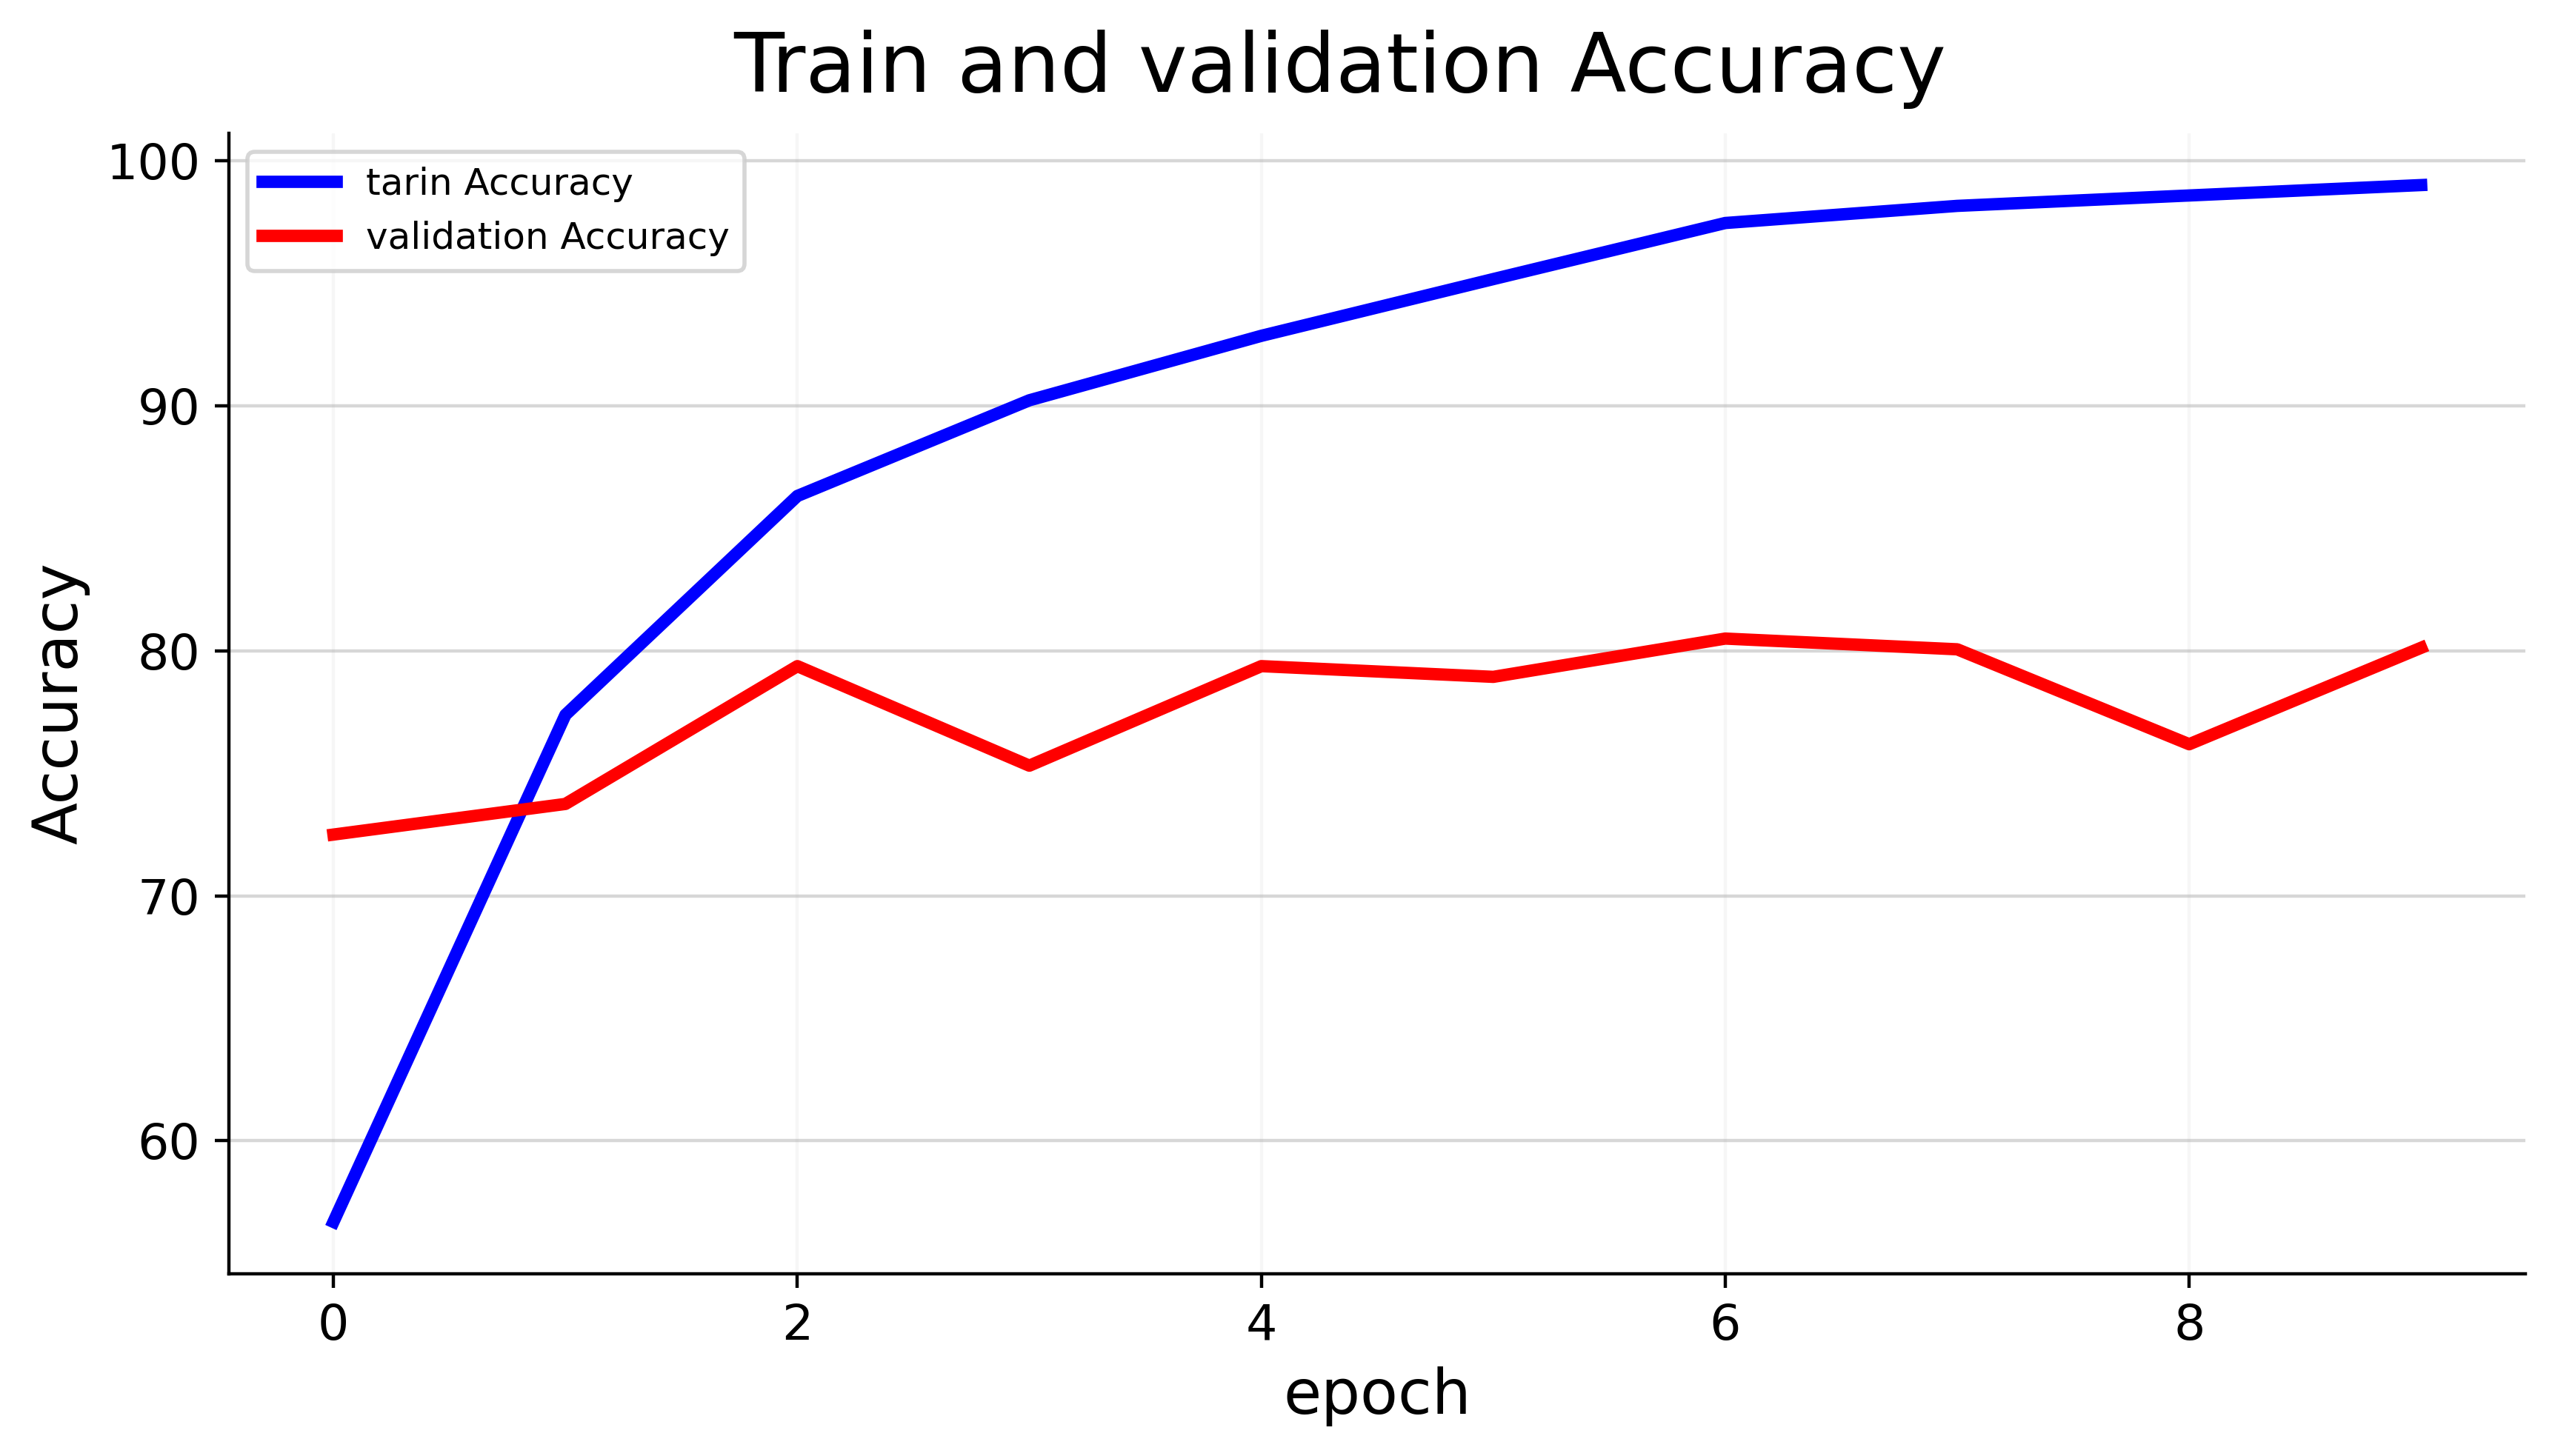

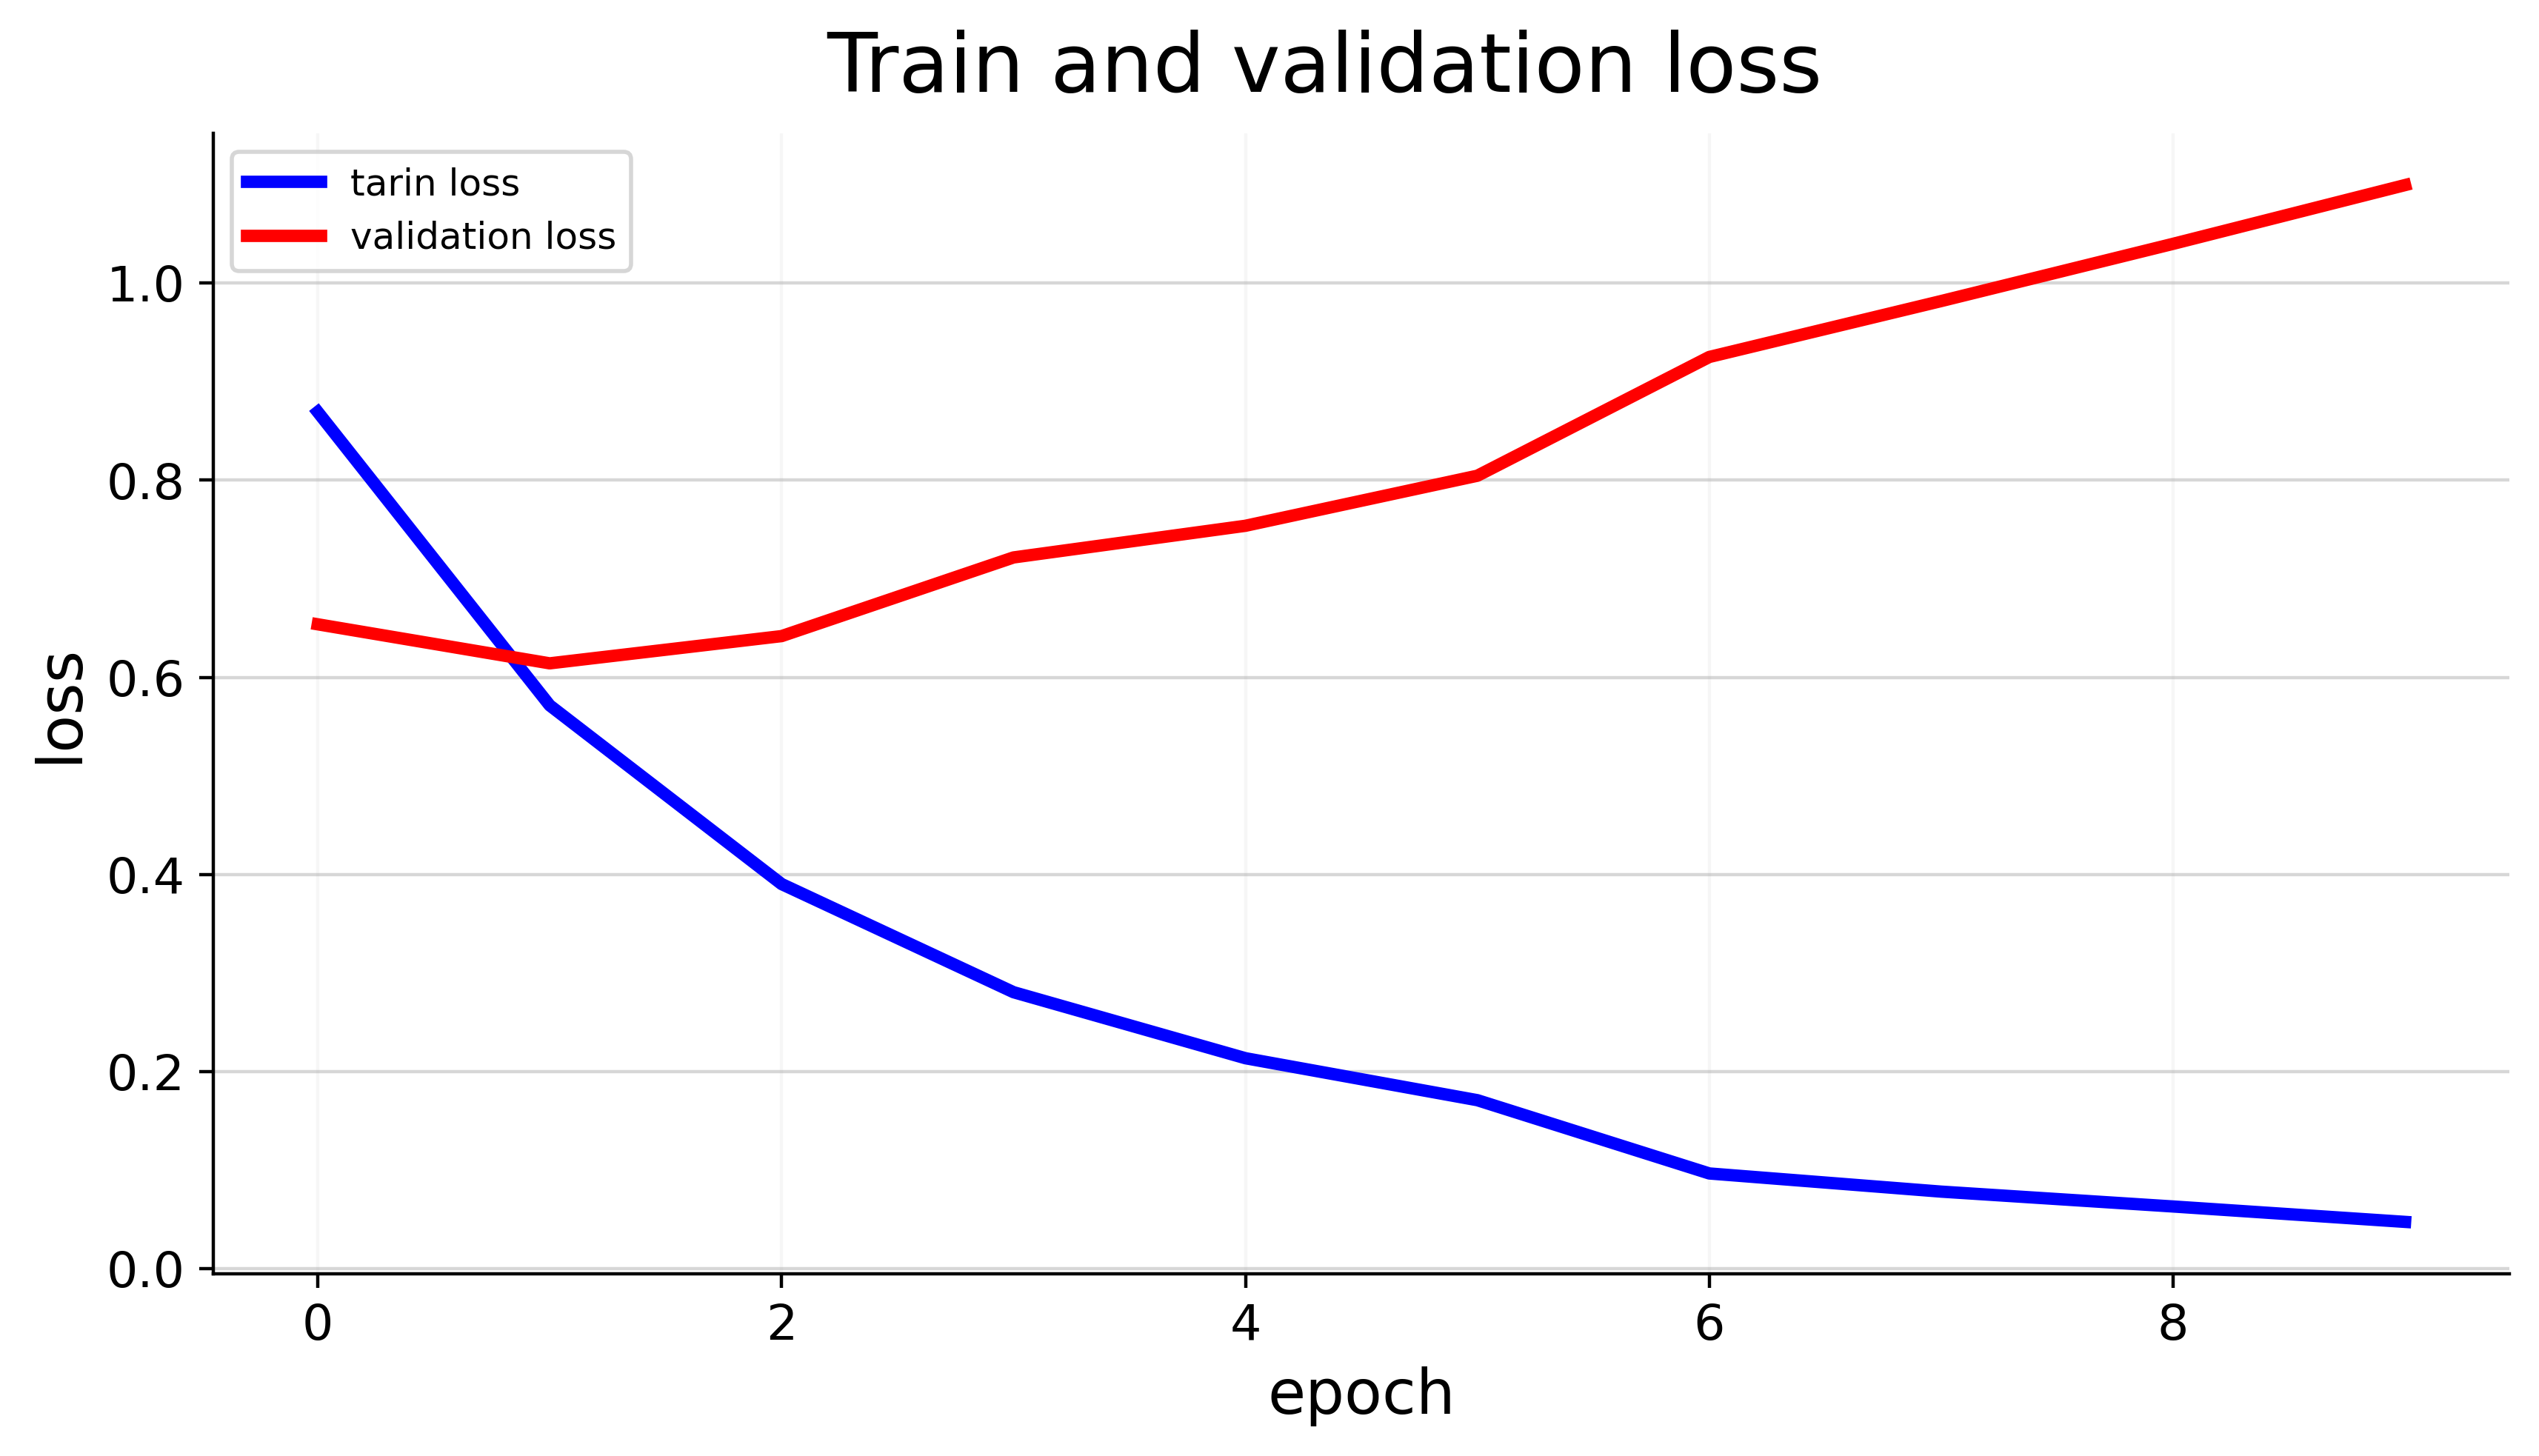

In [2]:
import pandas as pd
import numpy as np
import utils

df=pd.read_csv('./Model/'+Model_name+'/'+Model_name+'_00_10_report.csv')
# df=pd.read_csv('Model/bert-base-parsbert-uncased hidden_states 9/bert-base-parsbert-uncased hidden_states 9_00_10_report.csv')

def accu_2_int(df:pd.DataFrame,
               column:str='avg_train_acc_nopad_till_current_batch'):
    Dump = []
    for index in range(len(df)):
        Dump.append(float(np.array(df[column])[index][7:-18]))
    return Dump

train=df.query('mode == "train"').query('batch_index == 228')
test=df.query('mode == "val"').query('batch_index == 25')

utils.plot.result_plot(Model_name+"_Accuracy",
                       './Model/'+Model_name+'/',
                       "Accuracy",
                        accu_2_int(train,'avg_train_acc_till_current_batch'),
                        accu_2_int(test,'avg_val_acc_till_current_batch'),
                        DPI=400)


utils.plot.result_plot(Model_name+"_loss",
                       './Model/'+Model_name+'/',
                       "loss",
                        np.array(train['avg_train_loss_till_current_batch']),
                        np.array(test['avg_val_loss_till_current_batch']),
                        DPI=400)
